In [1]:
%matplotlib inline
%load_ext autotime

import math
import matplotlib as mpl
import matplotlib.pyplot as pt
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.metrics

In [2]:
import keras
import tensorflow as tf

Using TensorFlow backend.


time: 9.71 s


In [3]:
mpl.rcParams[ 'figure.figsize' ] = ( 18, 3 )

time: 766 µs


# load data

In [4]:
from keras.datasets import mnist
( train_x, train_y ), ( test_x, test_y ) = mnist.load_data()
train_x = train_x.astype( float ).reshape( train_x.shape[ 0 ], -1 )
train_x = sk.preprocessing.StandardScaler().fit_transform( train_x )
train_y = keras.utils.to_categorical( train_y )
test_x = test_x.astype( float ).reshape( test_x.shape[ 0 ], -1 )
test_x = sk.preprocessing.StandardScaler().fit_transform( test_x )
test_y = keras.utils.to_categorical( test_y )
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((60000, 784), (60000, 10), (10000, 784), (10000, 10))

time: 1.04 s


# parameters

In [5]:
hidden_dim = 512
n_layers = 100
batch_size = 10000
epochs = 100

time: 1.17 ms


# self normalizing neural network

In [6]:
def selu( x ):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return scale * tf.where( x >= 0., x, alpha * tf.nn.elu( x ) )

time: 34.3 ms


In [7]:
def init( shape, dtype=None ):
    return tf.random_normal( shape, stddev=tf.sqrt( 1. / shape[ 1 ] ) )

time: 27.8 ms


In [8]:
ms1 = []
ms1.append( keras.models.Sequential() )
ms1[ 0 ].add( keras.layers.Dense( hidden_dim, input_shape=train_x.shape[ 1: ], kernel_initializer=init ) )
ms1[ 0 ].add( keras.layers.Activation( selu ) )
for i in range( n_layers ):
    ms1.append( keras.models.Sequential() )
    ms1[ i + 1 ].add( keras.layers.Dense( hidden_dim, input_shape=( hidden_dim, ), kernel_initializer=init ) )
    ms1[ i + 1 ].add( keras.layers.Activation( selu ) )

time: 897 ms


In [9]:
m1 = keras.models.Sequential()
for i in ms1:
    m1.add( i )
m1.add( keras.layers.Dense( train_y.shape[ 1 ], kernel_initializer='glorot_normal' ) )
m1.add( keras.layers.Activation( 'softmax' ) )
m1.compile( loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=[ 'acc' ] )

time: 439 ms


In [10]:
h1 = m1.fit( train_x, train_y, batch_size=batch_size, epochs=epochs, verbose=0 )

time: 3min 58s


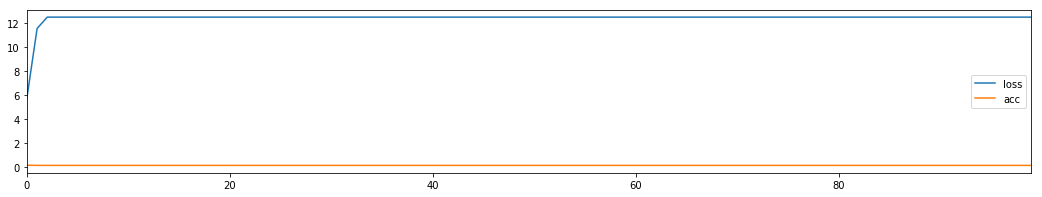

time: 145 ms


In [11]:
_ = pd.Series( h1.history[ 'loss' ], name='loss' ).plot.line( legend=True )
_ = pd.Series( h1.history[ 'acc' ], name='acc' ).plot.line( legend=True )

In [12]:
sk.metrics.accuracy_score( np.argmax( train_y, 1 ), np.argmax( m1.predict( train_x, batch_size=batch_size ), 1 ) )

0.098716666666666661

time: 1.25 s


In [13]:
ps = []
p = train_x
ps.append( tuple( ( p.mean(), p.var() ) ) )
for i in range( len( ms1 ) ):
    p = ms1[ i ].predict( p, batch_size=batch_size )
    ps.append( tuple( ( p.mean(), p.var() ) ) )

time: 38.4 s


In [14]:
print( 'layer\tmean\tvar' )
for i, p in enumerate( ps ):
    print( '%r\t%r\t%r' % ( i, p[ 0 ], p[ 1 ] ) )

layer	mean	var
0	-2.1974863349995617e-18	0.91454081632655582
1	0.039037514	1.3661046
2	0.084470123	1.7262069
3	0.19598107	2.4948256
4	0.32964149	3.5941908
5	0.51522207	5.0907264
6	0.7142598	7.0752225
7	1.0142425	9.9000301
8	1.2534444	13.01276
9	1.6442024	17.210638
10	1.8772147	21.454012
11	2.0101578	24.997662
12	2.4419577	30.654345
13	2.754256	36.748608
14	3.1371644	44.641529
15	3.6360178	53.016087
16	3.4375231	56.3582
17	4.1025376	67.175369
18	4.1722574	78.065834
19	4.5797668	87.527367
20	4.6371818	95.264381
21	5.2076564	101.92229
22	6.1744809	123.2802
23	5.939724	130.72391
24	6.7336726	153.12012
25	7.2260222	169.10301
26	7.2421446	180.8606
27	8.134182	212.40987
28	9.2850161	255.43736
29	9.5055342	290.24994
30	10.46689	336.76694
31	11.233859	348.93759
32	11.202724	376.09003
33	12.138782	400.8002
34	13.441179	500.68973
35	12.866833	535.88422
36	14.356503	558.44653
37	16.450024	736.62494
38	21.239067	1018.1851
39	20.870756	1287.6281
40	26.033743	1534.8712
41	28.798086	2221.6646
42	37.13

layer # 0
mean: -3.91306e-05
var: 0.00197388


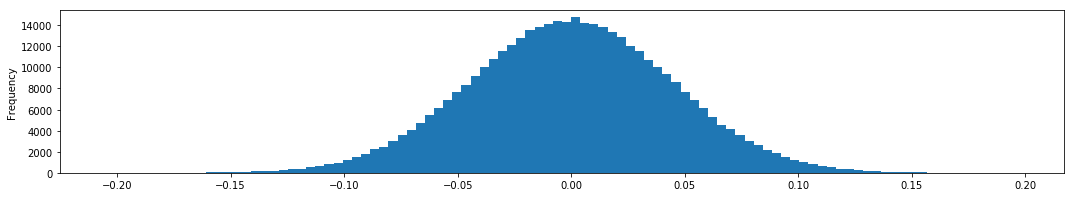

time: 2.91 s


In [15]:
n = 0
t = [ weights.flatten() for layer in ms1[ n ].layers for weights in layer.get_weights() if weights.ndim == 2 ]
_ = pd.Series( t[ -1 ] ).plot.hist( bins=100 )
print( 'layer #', n )
print( 'mean:', np.mean( t[ -1 ] ) )
print( 'var:', np.var( t[ -1 ] ) )

layer # 33
mean: -0.000100048
var: 0.00198454


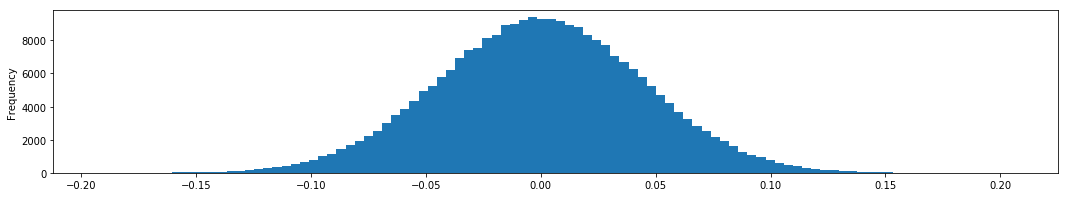

time: 1.89 s


In [16]:
n = len( ms1 ) // 3
t = [ weights.flatten() for layer in ms1[ n ].layers for weights in layer.get_weights() if weights.ndim == 2 ]
_ = pd.Series( t[ -1 ] ).plot.hist( bins=100 )
print( 'layer #', n )
print( 'mean:', np.mean( t[ -1 ] ) )
print( 'var:', np.var( t[ -1 ] ) )

layer # 66
mean: -3.80539e-05
var: 0.00198551


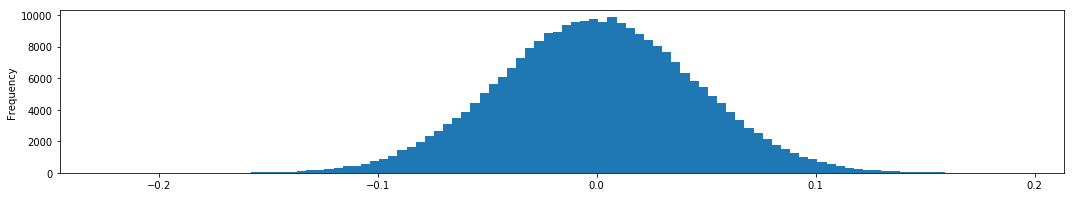

time: 1.89 s


In [17]:
n = len( ms1 ) // 3 * 2
t = [ weights.flatten() for layer in ms1[ n ].layers for weights in layer.get_weights() if weights.ndim == 2 ]
_ = pd.Series( t[ -1 ] ).plot.hist( bins=100 )
print( 'layer #', n )
print( 'mean:', np.mean( t[ -1 ] ) )
print( 'var:', np.var( t[ -1 ] ) )

layer # 100
mean: 9.08152e-05
var: 0.0019789


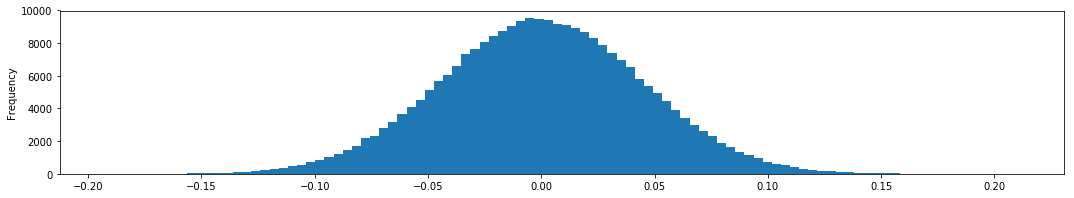

time: 1.94 s


In [18]:
n = len( ms1 ) - 1
t = [ weights.flatten() for layer in ms1[ n ].layers for weights in layer.get_weights() if weights.ndim == 2 ]
_ = pd.Series( t[ -1 ] ).plot.hist( bins=100 )
print( 'layer #', n )
print( 'mean:', np.mean( t[ -1 ] ) )
print( 'var:', np.var( t[ -1 ] ) )

# batch normalization

In [19]:
ms2 = []
ms2.append( keras.models.Sequential() )
ms2[ 0 ].add( keras.layers.Dense( hidden_dim, input_shape=train_x.shape[ 1: ], kernel_initializer=init ) )
ms2[ 0 ].add( keras.layers.BatchNormalization() )
ms2[ 0 ].add( keras.layers.advanced_activations.ELU() )
for i in range( n_layers ):
    ms2.append( keras.models.Sequential() )
    ms2[ i + 1 ].add( keras.layers.Dense( hidden_dim, input_shape=( hidden_dim, ), kernel_initializer=init ) )
    ms2[ i + 1 ].add( keras.layers.BatchNormalization() )
    ms2[ i + 1 ].add( keras.layers.advanced_activations.ELU() )

time: 3.17 s


In [20]:
m2 = keras.models.Sequential()
for i in ms2:
    m2.add( i )
m2.add( keras.layers.Dense( train_y.shape[ 1 ], kernel_initializer='glorot_normal' ) )
m2.add( keras.layers.Activation( 'softmax' ) )
m2.compile( loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=[ 'acc' ] )

time: 2.08 s


In [21]:
h2 = m2.fit( train_x, train_y, batch_size=batch_size, epochs=epochs, verbose=0 )

time: 5min 13s


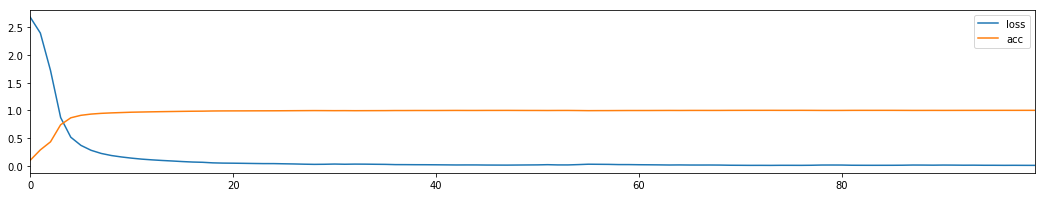

time: 142 ms


In [22]:
_ = pd.Series( h2.history[ 'loss' ], name='loss' ).plot.line( legend=True )
_ = pd.Series( h2.history[ 'acc' ], name='acc' ).plot.line( legend=True )

In [23]:
sk.metrics.accuracy_score( np.argmax( train_y, 1 ), np.argmax( m2.predict( train_x, batch_size=batch_size ), 1 ) )

0.99646666666666661

time: 2.53 s


In [24]:
ps = []
p = train_x
ps.append( tuple( ( p.mean(), p.var() ) ) )
for i in range( len( ms2 ) ):
    p = ms2[ i ].predict( p, batch_size=batch_size )
    ps.append( tuple( ( p.mean(), p.var() ) ) )

time: 2min 8s


In [25]:
print( 'layer\tmean\tvar' )
for i, p in enumerate( ps ):
    print( '%r\t%r\t%r' % ( i, p[ 0 ], p[ 1 ] ) )

layer	mean	var
0	-2.1974863349995617e-18	0.91454081632655582
1	0.1401336	0.60767025
2	0.14818682	0.61666769
3	0.15357472	0.62816286
4	0.15702024	0.63094896
5	0.15877095	0.63770586
6	0.16112471	0.63981575
7	0.16019608	0.64688247
8	0.16480598	0.6495828
9	0.1631148	0.65573424
10	0.16329603	0.65539479
11	0.16663006	0.66645193
12	0.16672735	0.66766024
13	0.16349325	0.66799653
14	0.16437468	0.67112637
15	0.16673313	0.67722207
16	0.1657843	0.68097448
17	0.16750482	0.68117929
18	0.16230011	0.68422806
19	0.16464365	0.68420833
20	0.16380534	0.68223006
21	0.16645859	0.68921107
22	0.16479428	0.69394445
23	0.16437262	0.69287819
24	0.17077674	0.70062017
25	0.16904186	0.69222695
26	0.16870059	0.69695336
27	0.16908891	0.70084268
28	0.16716936	0.69625407
29	0.16678877	0.70008785
30	0.16430813	0.70227808
31	0.16669634	0.70095921
32	0.16692281	0.70036739
33	0.1671859	0.70420593
34	0.16508619	0.70113081
35	0.16825183	0.70166779
36	0.163395	0.70759839
37	0.1672568	0.70159268
38	0.1658242	0.69636154
39	0.16

layer # 0
mean: -8.42219e-05
var: 0.00201307


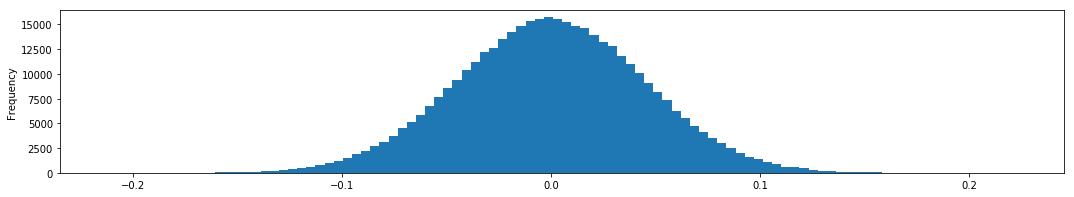

time: 3.01 s


In [26]:
n = 0
t = [ weights.flatten() for layer in ms2[ n ].layers for weights in layer.get_weights() if weights.ndim == 2 ]
_ = pd.Series( t[ -1 ] ).plot.hist( bins=100 )
print( 'layer #', n )
print( 'mean:', np.mean( t[ -1 ] ) )
print( 'var:', np.var( t[ -1 ] ) )

layer # 33
mean: 1.29255e-05
var: 0.00199421


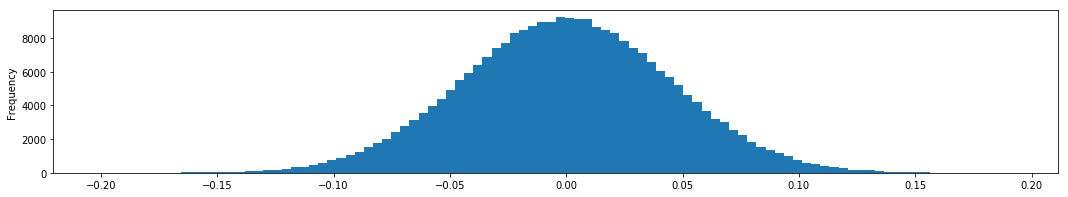

time: 2.14 s


In [27]:
n = len( ms2 ) // 3
t = [ weights.flatten() for layer in ms2[ n ].layers for weights in layer.get_weights() if weights.ndim == 2 ]
_ = pd.Series( t[ -1 ] ).plot.hist( bins=100 )
print( 'layer #', n )
print( 'mean:', np.mean( t[ -1 ] ) )
print( 'var:', np.var( t[ -1 ] ) )

layer # 66
mean: -0.000102197
var: 0.00199937


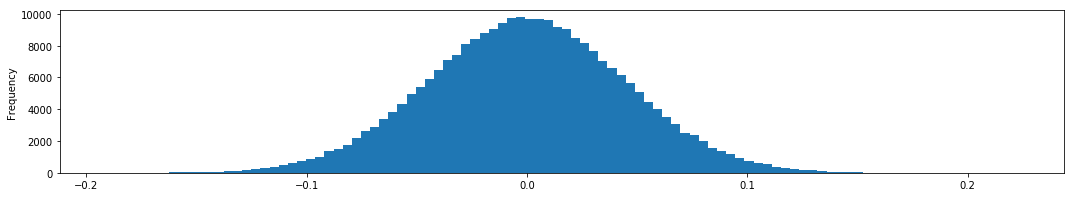

time: 2.1 s


In [28]:
n = len( ms2 ) // 3 * 2
t = [ weights.flatten() for layer in ms2[ n ].layers for weights in layer.get_weights() if weights.ndim == 2 ]
_ = pd.Series( t[ -1 ] ).plot.hist( bins=100 )
print( 'layer #', n )
print( 'mean:', np.mean( t[ -1 ] ) )
print( 'var:', np.var( t[ -1 ] ) )

layer # 100
mean: 7.08685e-05
var: 0.00198898


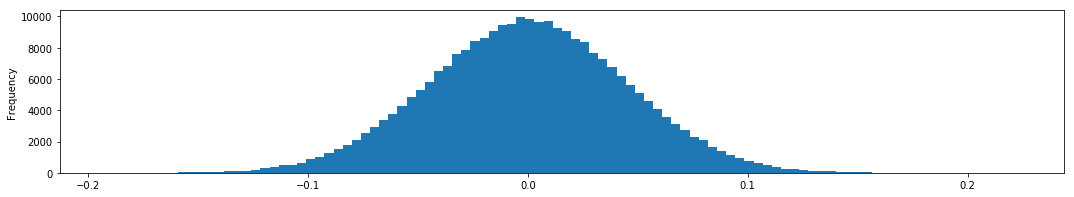

time: 2.03 s


In [29]:
n = len( ms2 ) - 1
t = [ weights.flatten() for layer in ms2[ n ].layers for weights in layer.get_weights() if weights.ndim == 2 ]
_ = pd.Series( t[ -1 ] ).plot.hist( bins=100 )
print( 'layer #', n )
print( 'mean:', np.mean( t[ -1 ] ) )
print( 'var:', np.var( t[ -1 ] ) )

# elu only

In [30]:
ms3 = []
ms3.append( keras.models.Sequential() )
ms3[ 0 ].add( keras.layers.Dense( hidden_dim, input_shape=train_x.shape[ 1: ], kernel_initializer=init ) )
ms3[ 0 ].add( keras.layers.BatchNormalization() )
ms3[ 0 ].add( keras.layers.advanced_activations.ELU() )
for i in range( n_layers ):
    ms3.append( keras.models.Sequential() )
    ms3[ i + 1 ].add( keras.layers.Dense( hidden_dim, input_shape=( hidden_dim, ), kernel_initializer=init ) )
    ms3[ i + 1 ].add( keras.layers.BatchNormalization() )
    ms3[ i + 1 ].add( keras.layers.advanced_activations.ELU() )

time: 3.37 s


In [31]:
m3 = keras.models.Sequential()
for i in ms3:
    m3.add( i )
m3.add( keras.layers.Dense( train_y.shape[ 1 ], kernel_initializer='glorot_normal' ) )
m3.add( keras.layers.Activation( 'softmax' ) )
m3.compile( loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=[ 'acc' ] )

time: 1.83 s


In [32]:
h3 = m3.fit( train_x, train_y, batch_size=batch_size, epochs=epochs, verbose=0 )

time: 5min 14s


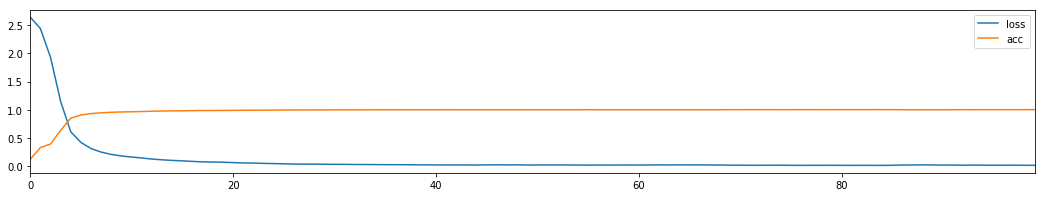

time: 140 ms


In [33]:
_ = pd.Series( h3.history[ 'loss' ], name='loss' ).plot.line( legend=True )
_ = pd.Series( h3.history[ 'acc' ], name='acc' ).plot.line( legend=True )

In [34]:
sk.metrics.accuracy_score( np.argmax( train_y, 1 ), np.argmax( m3.predict( train_x, batch_size=batch_size ), 1 ) )

0.99704999999999999

time: 3.49 s


In [35]:
ps = []
p = train_x
ps.append( tuple( ( p.mean(), p.var() ) ) )
for i in range( len( ms3 ) ):
    p = ms3[ i ].predict( p, batch_size=batch_size )
    ps.append( tuple( ( p.mean(), p.var() ) ) )

time: 3min 43s


In [36]:
print( 'layer\tmean\tvar' )
for i, p in enumerate( ps ):
    print( '%r\t%r\t%r' % ( i, p[ 0 ], p[ 1 ] ) )

layer	mean	var
0	-2.1974863349995617e-18	0.91454081632655582
1	0.14088614	0.60709476
2	0.14882731	0.62244833
3	0.15504415	0.62951064
4	0.15818466	0.63502508
5	0.16084394	0.6436432
6	0.16102354	0.64490885
7	0.16256249	0.65229768
8	0.16384175	0.65020037
9	0.16586444	0.66133404
10	0.16495842	0.66534698
11	0.16781542	0.67545795
12	0.16702813	0.68261218
13	0.16761263	0.68775588
14	0.17271242	0.69926924
15	0.17258862	0.70011103
16	0.17164038	0.71086556
17	0.17081642	0.71241146
18	0.17171715	0.72351402
19	0.17772056	0.72590196
20	0.17599678	0.73044473
21	0.17382561	0.73411274
22	0.17363217	0.73471206
23	0.17348889	0.72905231
24	0.17183477	0.73006046
25	0.17766145	0.7342782
26	0.17842466	0.72932822
27	0.17705418	0.74744672
28	0.17600852	0.74274051
29	0.17608842	0.75037813
30	0.1733927	0.74758953
31	0.17566383	0.74688137
32	0.17676309	0.73222697
33	0.17314473	0.73877293
34	0.17532654	0.73253447
35	0.17381813	0.72741723
36	0.17185679	0.73121816
37	0.17306472	0.72159791
38	0.17088836	0.72170269
3

layer # 0
mean: -0.000135253
var: 0.00200891


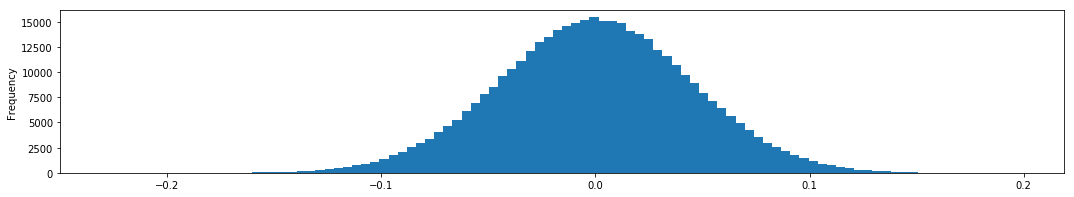

time: 3.14 s


In [37]:
n = 0
t = [ weights.flatten() for layer in ms3[ n ].layers for weights in layer.get_weights() if weights.ndim == 2 ]
_ = pd.Series( t[ -1 ] ).plot.hist( bins=100 )
print( 'layer #', n )
print( 'mean:', np.mean( t[ -1 ] ) )
print( 'var:', np.var( t[ -1 ] ) )

layer # 33
mean: 4.41613e-05
var: 0.00199095


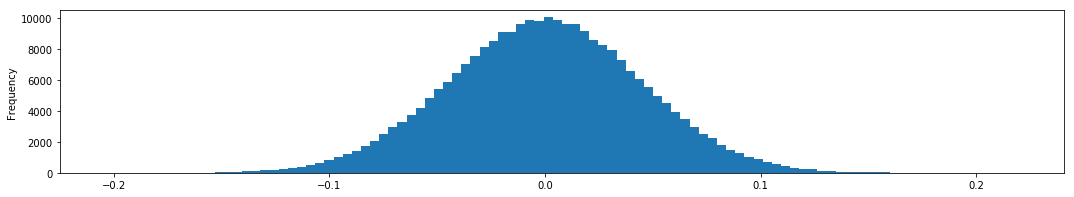

time: 2.29 s


In [38]:
n = len( ms3 ) // 3
t = [ weights.flatten() for layer in ms3[ n ].layers for weights in layer.get_weights() if weights.ndim == 2 ]
_ = pd.Series( t[ -1 ] ).plot.hist( bins=100 )
print( 'layer #', n )
print( 'mean:', np.mean( t[ -1 ] ) )
print( 'var:', np.var( t[ -1 ] ) )

layer # 66
mean: -0.000122973
var: 0.00199655


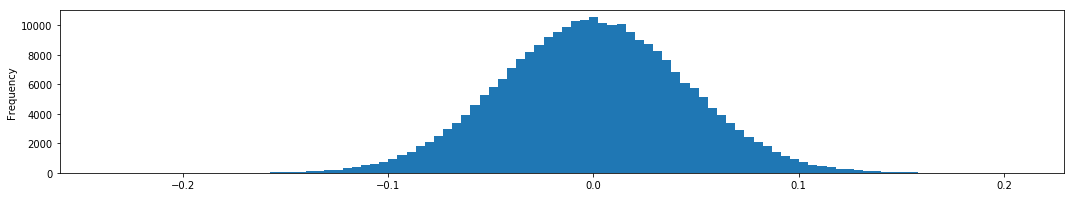

time: 2.3 s


In [39]:
n = len( ms3 ) // 3 * 2
t = [ weights.flatten() for layer in ms3[ n ].layers for weights in layer.get_weights() if weights.ndim == 2 ]
_ = pd.Series( t[ -1 ] ).plot.hist( bins=100 )
print( 'layer #', n )
print( 'mean:', np.mean( t[ -1 ] ) )
print( 'var:', np.var( t[ -1 ] ) )

layer # 100
mean: -3.95749e-05
var: 0.00199318


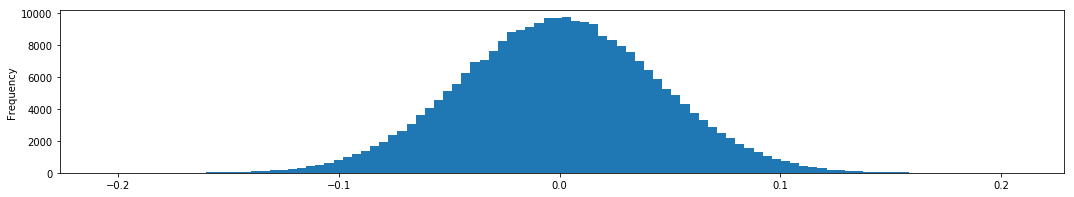

time: 2.3 s


In [40]:
n = len( ms3 ) - 1
t = [ weights.flatten() for layer in ms3[ n ].layers for weights in layer.get_weights() if weights.ndim == 2 ]
_ = pd.Series( t[ -1 ] ).plot.hist( bins=100 )
print( 'layer #', n )
print( 'mean:', np.mean( t[ -1 ] ) )
print( 'var:', np.var( t[ -1 ] ) )

# compare

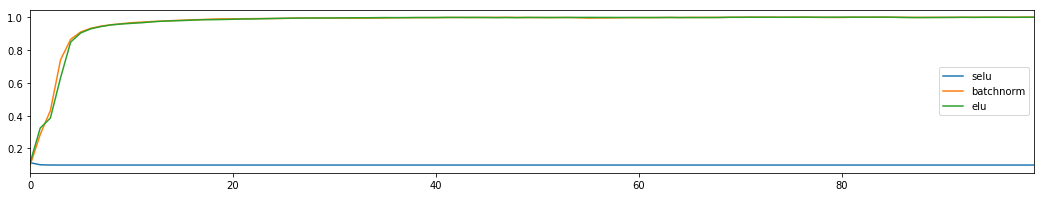

time: 164 ms


In [42]:
_ = pd.Series( h1.history[ 'acc' ], name='selu' ).plot.line( legend=True )
_ = pd.Series( h2.history[ 'acc' ], name='batchnorm' ).plot.line( legend=True )
_ = pd.Series( h3.history[ 'acc' ], name='elu' ).plot.line( legend=True )

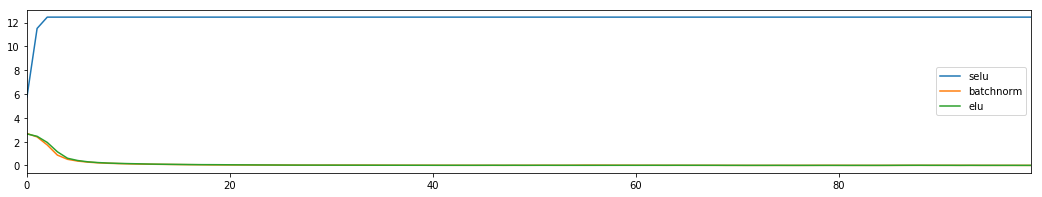

time: 165 ms


In [43]:
_ = pd.Series( h1.history[ 'loss' ], name='selu' ).plot.line( legend=True )
_ = pd.Series( h2.history[ 'loss' ], name='batchnorm' ).plot.line( legend=True )
_ = pd.Series( h3.history[ 'loss' ], name='elu' ).plot.line( legend=True )

# check

In [44]:
def np_selu( x ):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return scale * np.where( x >= 0., x, alpha * np.exp( x ) - alpha )

time: 3.93 ms


In [45]:
t = train_x
print( t.shape )
for i in range( 20 ):
    w = np.random.normal( size=( train_x.shape[ 1 ], train_x.shape[ 1 ] ), scale=math.sqrt( 1. / train_x.shape[ 1 ] ) )
    t = np_selu( np.dot( t, w ) )
    print( '%r\t%r\t%r' % ( i, t.mean(), t.var() ) )

(60000, 784)
0	-0.010265291297054925	0.85272614543092851
1	-0.013911532321110738	0.83166286746921336
2	-0.015487985742662001	0.84300483458907027
3	-0.013918483642903138	0.87138417047468875
4	-0.0071974872096703373	0.90239071305778173
5	-0.0048967333308982978	0.91154406752127803
6	-0.01621857392543858	0.92283662044520576
7	-0.0092683446669222565	0.92948437626217462
8	-0.0018920264479308211	0.95397844818068134
9	0.0029629476787161207	0.96823182596755641
10	-0.00029355613368805937	0.97512152748916814
11	-0.004558519322396727	0.97796510999050801
12	-0.00050655827643823347	0.98075362206374617
13	0.0013078376210755808	0.98713693012407266
14	-0.006238669094667343	0.98828280758171672
15	0.0021844074406604783	0.98853961386338252
16	-0.0052851715885116821	0.98300081550216201
17	-0.0039038794191494316	0.9865338930386508
18	-0.0028349822296355525	0.98234193403479475
19	0.00029304764134885651	0.98878031467980454
time: 49.9 s


In [46]:
t = np.random.normal( size=( train_x.shape[ 0 ], train_x.shape[ 1 ] ) )
for i in range( 20 ):
    w = np.random.normal( size=( train_x.shape[ 1 ], train_x.shape[ 1 ] ), scale=math.sqrt( 1. / train_x.shape[ 1 ] ) )
    t = np_selu( np.dot( t, w ) )
    print( '%r\t%r\t%r' % ( i, t.mean(), t.var() ) )

0	-9.4717891535861813e-05	0.99969550782489802
1	-0.00020154242721468426	1.0014490863688055
2	-6.8985946314412984e-05	1.0010800203144745
3	-0.00029671508545528344	0.9984080528834971
4	-0.00046745559615070489	0.99892973744451041
5	5.3492840718193354e-05	1.0028396161197024
6	0.00089487657384553269	1.0037315100212008
7	0.00080704832395711937	1.0041658326789846
8	0.0011195510365853496	1.0102384697483882
9	0.0010694267284306607	1.0081138072587645
10	-0.00036988203116616669	0.99977444284566042
11	-9.1519787262968753e-05	0.9966269283182092
12	0.00018367847979665285	0.99240717878850671
13	-0.0014000858602421437	0.9900899115124312
14	-0.00038570198662004907	0.99546291734698655
15	-0.003235848927895091	0.99219375220071726
16	-0.00060448717256993405	0.99116773068958741
17	-0.0011106420272918309	0.98454286238935229
18	-0.0028379397365330414	0.98601173804950504
19	-0.00062363270284672358	0.98708783708919645
time: 51.9 s


In [47]:
t = np.random.normal( size=( 300, 200 ) )
for i in range( 20 ):
    w = np.random.normal( size=( 200, 200 ), scale=math.sqrt( 1. / 200 ) )
    t = np_selu( np.dot( t, w ) )
    print( '%r\t%r\t%r' % ( i, t.mean(), t.var() ) )

0	0.0018636968529558951	1.0036392457734613
1	0.0066140873171582452	1.0069874721909795
2	0.0049689395729891608	1.0028630103420473
3	0.0086869446192365911	1.0047275474299393
4	-0.0038476064420324093	0.98029898317855524
5	-0.0012242873791717239	0.97712325400939304
6	-0.011270080061772395	0.97447577718380685
7	-0.0041392830869269506	0.97015034210291218
8	-0.004395829827595032	0.97314511524705005
9	-0.0064623366091674725	0.95658697501348744
10	-0.0089048844805679536	0.94353392083801002
11	-0.0036239063377275669	0.96982296863028128
12	-0.010425185153199425	0.97041864280577494
13	-0.0041774420675692323	0.99078858288994398
14	-0.00082569894335187842	1.0165727180303088
15	-0.00016722389375736833	1.0144230207587153
16	-0.013645745671506688	0.99195296498409335
17	0.0028313312453843139	0.98650372675177855
18	-0.0029482104953051664	1.0108423476467547
19	0.0067965123570641241	1.011542952219745
time: 129 ms
